In [1]:
import pandas as pd
import igraph as ig
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from collections import deque

In [2]:
datadir='../Datasets/'

### Problem 2

The link to the Grid network (Europe) also has data for North America. Perform a similar type of EDA as in Section 1.12 (in particular, replicate Table 1.1) for that graph, including getting and preparing the data.

In [3]:
## reading raw data files, choosing only the required columns, and saving in processed format
vertices_raw = pd.read_csv(datadir + 'GridNorthAmerica/gridkit_north_america-highvoltage-vertices.csv')
vertices_header = ['v_id', 'lon', 'lat', 'typ']
vertices_raw.to_csv(datadir + 'GridNorthAmerica/gridkit_north_america-highvoltage.vertices', columns=vertices_header, index=False)

edges_raw = pd.read_csv(datadir + 'GridNorthAmerica/gridkit_north_america-highvoltage-links.csv')
edges_header = ['v_id_1', 'v_id_2']
edges_raw.to_csv(datadir + 'GridNorthAmerica/gridkit_north_america-highvoltage.edges', columns=edges_header, index=False, header=False, sep=' ')

In [17]:
## build graph from edge list
gr = ig.Graph.Read_Ncol(datadir+'GridNorthAmerica/gridkit_north_america-highvoltage.edges', directed=False)
gr = gr.simplify()

## compute Table 1.1 quantities for the NA Grid network
def baseStats(G):
    deg = G.degree()
    return [G.vcount(),G.ecount(),np.min(deg),np.mean(deg),np.median(deg),np.quantile(deg,.99),
            np.max(deg),G.diameter(),np.max(G.clusters().membership)+1,G.clusters().giant().vcount(),
            sum([x==0 for x in G.degree()]),G.transitivity_undirected(mode='nan'),
            G.transitivity_avglocal_undirected(mode='nan')]
S = []
S.append(['Grid'] + baseStats(gr))
D = pd.DataFrame(S,columns=['graph','nodes','edges',r'$d_{min}$',r'$d_{mean}$',r'$d_{median}$',
                            r'$d_{quant_{99}}$',r'$d_{max}$','diameter','components','largest',
                            'isolates',r'$C_{glob}$',r'$C_{loc}$']).transpose()
D

,0
graph,Grid
nodes,16167
edges,20242
$d_{min}$,1
$d_{mean}$,2.504113
$d_{median}$,2.0
$d_{quant_{99}}$,7.0
$d_{max}$,22
diameter,138
components,34


### Problem 3

Consider the GitHub (ml) graph on 9739 nodes
1. Find the number of walks of length 5.

In [3]:
## read edges and make graph
github_df = pd.read_csv(datadir+'GitHubDevelopers/musae_git_edges.csv')
gh = ig.Graph.DataFrame(github_df, directed=False)

## read node features
X = pd.read_csv(datadir+'GitHubDevelopers/musae_git_target.csv')

## map node names in edgelist to indices in the graph
idx = [int(i) for i in gh.vs['name']]
sorterIndex = dict(zip(idx,range(len(idx))))
X['Rank'] = X['id'].map(sorterIndex) 
X.sort_values(['Rank'], ascending=[True],inplace=True)
X.dropna(inplace=True)

lbl = ['web','ml']     ## node labels
gh.vs['lbl'] = [lbl[i] for i in list(X['ml_target'])]

## build the ml subgraphs
gh_ml = gh.subgraph([v for v in gh.vs() if v['lbl']=='ml'])

In [8]:
## first some pre-processing to reduce the space we count over. We care only about the subgraph
## induced by nodes of degree at least 1
gh_ml_1p = gh_ml.subgraph([v for v in gh_ml.vs() if len(gh_ml.neighbors(v))>=1])
print("Size of subgraph: ", gh_ml_1p.vcount())
print("Size of subgraph e: ", gh_ml_1p.ecount())

## modified DFS starting from each node to count all neighbours up to distance 4 away
path_count = 0

def DFS(v, dist):
    global path_count
    for next_v in gh_ml_1p.neighbors(v):
        if dist + 1 < 5:
            DFS(next_v, dist+1)
        else:
            path_count += 1
    
node_num = 1
for v in gh_ml_1p.vs.indices:
    
    DFS(v, 0)

    node_num += 1
    if node_num % 1000 == 0:
        print(node_num)
            
print("Total number of walks of length 5: ", path_count)

Size of subgraph:  7431
Size of subgraph e:  19684
1000
2000
3000
4000
5000
6000
7000
Total number of walks of length 5:  36175204754


2. Find the number of cycles of length 4 (induced, that is, without chords).

In [5]:
## We care only about the subgraph induced by nodes of degree at least 2
gh_ml_2p = gh_ml.subgraph([v for v in gh_ml.vs() if len(gh_ml.neighbors(v))>=2])
print("Size of subgraph: ", gh_ml_2p.vcount())

## to get the number of cycles of length 4 (including those with chords), 
## from each node, go to each neighbour, and look for a simple path back of length 3
all_cycles = set()
for v in gh_ml_2p.vs():
    neighbourlist = gh_ml_2p.neighbors(v)
    for u in neighbourlist:
        paths = gh_ml_2p.get_all_simple_paths(gh_ml_2p.vs[u], to=v, cutoff=3)
        path3 = [tuple(sorted(i)) for i in paths if len(i)==4]
        for p in path3:
            if p not in all_cycles:
                all_cycles.add(p)

## for each unique cycle, check if there are chords 
## if there are no chords, taking the intersection of all neighbours of nodes on a cycle, and then the intersection
## with all the nodes in the cycle, will return an empty set
chordless_cycles = 0
for cycle in all_cycles:
    neighbours_sets = []
    for v in cycle:
        neighbours_sets.append(set(gh_ml_2p.neighbors(v)))
    neighbours_intersect = neighbours_sets[0].intersection(neighbours_sets[1], neighbours_sets[2], neighbours_sets[3])
    if set(cycle).intersection(neighbours_intersect) == set():
        chordless_cycles += 1
        
print("Number of cycles of length 4: ", chordless_cycles)

Size of subgraph:  4959
Number of cycles of length 4:  146316


### Problem 4

Consider the airport graph. The first 3 fields are: the origin, the destination, and, respectively, the number of passengers. This graph is weighted and directed; the weight of a directed edge uv corresponds to the number of passengers travelling from airport u to airport v. 

1. Plot the cumulative degree distribution in a log-log plot. Find the slope of the line obtained via linear regression.


power law exponent: 0.058376556378227765


Text(0, 0.5, 'log(No. nodes with smaller or equal degree)')

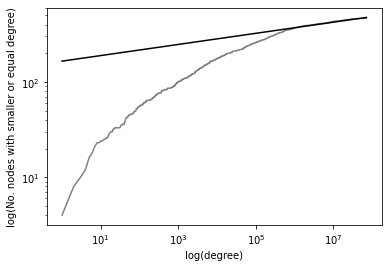

In [74]:
## read edges and make graph
airports_df = pd.read_csv(datadir+'Airport/connections.csv')
tuples = [tuple(x) for x in airports_df.values]

## get degree list and calculate cumulative distribution
ga = ig.Graph.TupleList(tuples, directed = True, edge_attrs = ["weight"])
degrees = np.array(ga.strength(weights="weight"))
degrees = degrees[degrees>=1]
degree_distribution = np.histogram(degrees, bins=np.arange(min(degrees), max(degrees)+1))[0]
cum_deg_dist = np.cumsum(degree_distribution)

## plot
x = np.arange(min(degrees), max(degrees))
plt.loglog(x, cum_deg_dist, c='grey')

## perform linear regression
regressor = LinearRegression() 
x_log = np.log(x)
cum_deg_dist_log = np.log(cum_deg_dist)
regressor.fit(np.array(x_log).reshape(-1,1), cum_deg_dist_log)
print('power law exponent:',regressor.coef_[0])

plt.plot([min(degrees), max(degrees)],[np.exp(regressor.intercept_)*min(degrees)**regressor.coef_[0],np.exp(regressor.intercept_)*max(degrees)**regressor.coef_[0]],color='k')
plt.xlabel('log(degree)')
plt.ylabel('log(No. nodes with smaller or equal degree)')

2. Find the busiest airport.

In [77]:
deg_all = np.array(ga.strength(mode='all', weights="weight"))
max_ind = np.argmax(deg_all)
print("The busiest airport is: ", ga.vs['name'][max_ind])

The busiest airport is:  ATL


3. Find the number of strongly connected components.

In [52]:
strong_clusters = ga.clusters(mode='strong')
print("Number of strongly connected components: ", len(strong_clusters))

Number of strongly connected components:  40


4. Find the subgraph induced by all airports from California. Find the number of isolated nodes in this subgraph

In [58]:
loc_df = pd.read_csv(datadir+'Airport/airports_loc.csv')
cal_airports = loc_df.loc[loc_df['state']=='CA']
cal_ap_names = cal_airports['airport'].tolist()

## subgraph induced by all airports from california
ga_cal = ga.subgraph([v for v in ga.vs() if v['name'] in cal_ap_names])
degree = np.array(ga_cal.degree(mode='all'))
print("Number of isolated nodes: ", len(degree[degree==0]))

Number of isolated nodes:  9


### Problem 5

Take 100 random pairs of nodes in the European Grid network. For each pair plot a point (x,y) where x is the graph distance between the two nodes and y is the corresponding geographical distance (in km). Is there a correlation between the two distances?

In [3]:
## read edge list for the grid network and build undirected graph
gr = ig.Graph.Read_Ncol(datadir+'GridEurope/gridkit_europe-highvoltage.edges', directed=False)
gr = gr.simplify()

## read the vertices along with some of the attributes
X = pd.read_csv(datadir+'GridEurope/gridkit_europe-highvoltage.vertices')
idx = [int(i) for i in gr.vs['name']]
sorterIndex = dict(zip(idx,range(len(idx))))
X['Rank'] = X['v_id'].map(sorterIndex)
X.sort_values(['Rank'], ascending=[True],inplace=True)
X.dropna(inplace=True)
gr.vs['longitude'] = list(X['lon'])
gr.vs['latitude'] = list(X['lat'])
gr.vs['type'] = list(X['typ'])
gr.vs['layout'] = [(v['longitude'],v['latitude']) for v in gr.vs()] ## tuples with lat/lon
gr.vs['size'] = 3
gr.es['color'] = 'grey'
gr.vs['color'] = 'black'

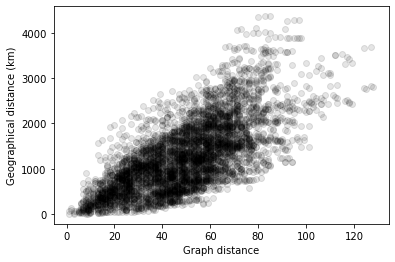

In [16]:
from geopy import distance

N = 100

sample_vertices = np.random.choice(gr.vs.indices, size=N, replace=False)

graph_dist = np.zeros([N, N])
geo_dist = np.zeros([N, N])

for i in range(len(sample_vertices)):
    for j in range(i):
        u = sample_vertices[i]
        v = sample_vertices[j]
        graph_dist[i,j] = gr.shortest_paths(source=u, target=v)[0][0]
        geo_dist[i,j] = distance.distance((gr.vs['latitude'][u], gr.vs['longitude'][u]), (gr.vs['latitude'][v], gr.vs['longitude'][v])).km
        
graph_dist = graph_dist.flatten()
geo_dist = geo_dist.flatten()

plt.scatter(graph_dist[graph_dist!=0], geo_dist[graph_dist!=0], c='k', alpha=0.1)
plt.xlabel("Graph distance")
plt.ylabel("Geographical distance (km)")
plt.show()
        
